In [60]:
import os
import tensorflow.keras as keras
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import tensorflow
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path= '/kaggle/input/uavid-semantic-segmentation-dataset/train/train'
test_path= '/kaggle/input/uavid-semantic-segmentation-dataset/test/test'
valid_path= '/kaggle/input/uavid-semantic-segmentation-dataset/valid/valid'

In [3]:
os.listdir(train_path+'/seq6/Labels')

['000400.png',
 '000300.png',
 '000500.png',
 '000600.png',
 '000900.png',
 '000100.png',
 '000200.png',
 '000000.png',
 '000700.png',
 '000800.png']

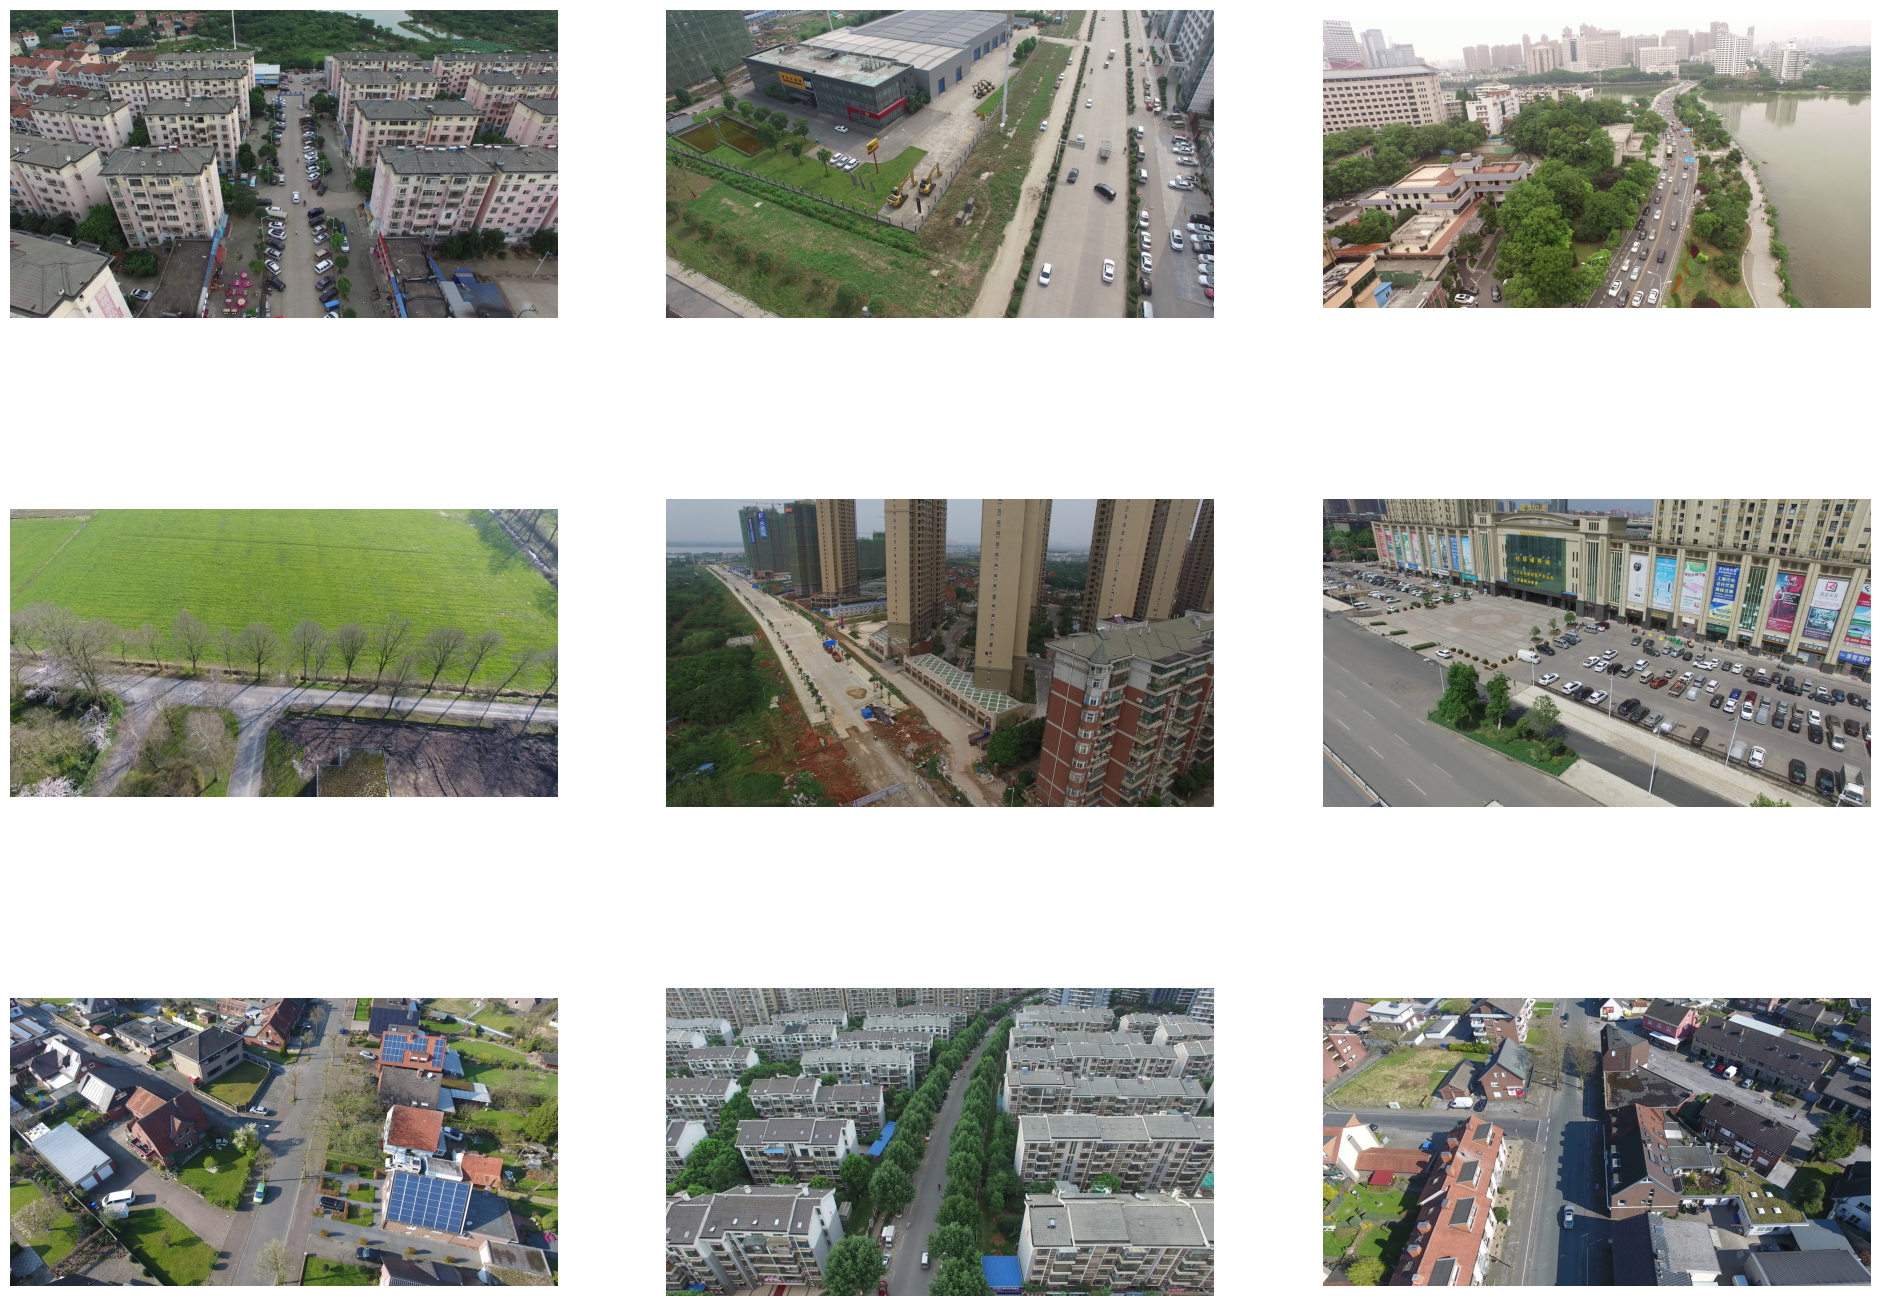

In [4]:
plt.figure(figsize=(24,18))
for i,seq in enumerate(os.listdir(train_path)):
    if i==9:
        break
    img_file = os.path.join(train_path,seq,'Images')
    img_name = os.listdir(img_file)
    first_img_path = os.path.join(img_file,random.choice(img_name)) 
    img=Image.open(first_img_path)
    img = np.array(img)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

> # **size of images**

In [5]:
size = []
for seq in (os.listdir(train_path)):
    img_file = os.path.join(train_path,seq,'Images')
    img_name = os.listdir(img_file)
    first_img_path = os.path.join(img_file,random.choice(img_name)) 
    img=Image.open(first_img_path)
    img = np.array(img)
    size.append(img.shape)
print('The Sizes of image',list(set(size)))

The Sizes of image [(2160, 3840, 3), (2160, 4096, 3)]


> # **Image Preprocessing** 

In [6]:
os.makedirs('/kaggle/working/train',exist_ok=True)
os.makedirs('/kaggle/working/test',exist_ok=True)
os.makedirs('/kaggle/working/test/image',exist_ok=True)
os.makedirs('/kaggle/working/train/image',exist_ok=True)
os.makedirs('/kaggle/working/train/label',exist_ok=True)

In [7]:
cnt=1

In [8]:
def move_img_to(source,distination,test=False):
    global cnt
    for seq in os.listdir(source):
        img_file = os.path.join(source,seq,'Images')
        label_file = os.path.join(source,seq,'Labels')
        img_name = os.listdir(img_file)
        for img in img_name:
            img_path = os.path.join(img_file,img) 
            label_path = os.path.join(label_file,img) 
            des_img = os.path.join(distination,'image',f'{cnt}{os.path.splitext(img)[1]}')
            des_label = os.path.join(distination,'label',f'{cnt}{os.path.splitext(img)[1]}')
            shutil.copy(img_path,des_img)
            if test ==False:
                shutil.copy(label_path,des_label)
            cnt+=1

In [9]:
move_img_to(train_path,'/kaggle/working/train')
move_img_to(valid_path,'/kaggle/working/train')
move_img_to(test_path,'/kaggle/working/test',True)

**remove directory**

In [10]:
# shutil.rmtree('/kaggle/working/train/image/1.png')

# **Training data**

In [11]:
train_img = []
train_label = []
test_img=[]
def to_list(src,gray):
    s1=[]
    for img_name in os.listdir(src):
        img_path=os.path.join(src,img_name)
        img=cv2.imread(img_path)
        size = (1024, 1024)
        if gray:
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,size,interpolation=cv2.INTER_NEAREST)
        else:
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img=cv2.resize(img,size)
        s1.append(img)
    s1 = np.array(s1)
    return s1

In [12]:
train_i='/kaggle/working/train/image'
train_l='/kaggle/working/train/label'
test_i='/kaggle/working/test/image'
train_img = to_list(train_i,False)
train_label=to_list(train_l,True)
test_img=to_list(test_i,False)

In [13]:
len(train_label)

270

In [14]:
gc.collect()
gc.collect()

0

In [15]:
np.unique(train_label[3])

array([  0,  34,  38,  57,  75,  79,  90, 113], dtype=uint8)

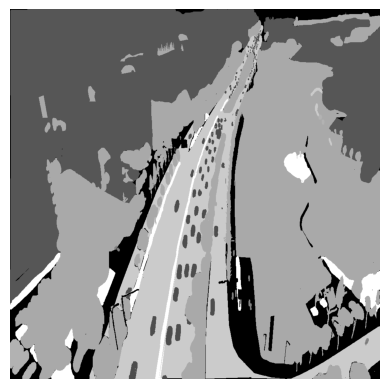

In [16]:
plt.imshow(train_label[0],cmap='gray')
plt.axis('off')
plt.show()

In [17]:
CLASSES = ['clutter', 'static_car' ,'building', 'tree', 'vegetation', 'human', 'road', 'moving_car']
class_values = np.unique(train_label[0])
num_images = len(train_label)
height, width = train_label[0].shape
num_classes = len(CLASSES)

# Pre-allocate memory for masks
masks = np.zeros((num_images, height, width, num_classes), dtype=np.uint8)

# Efficient mask generation
for idx in range(num_images):
    label = train_label[idx]  # Get the current mask
    for class_idx, val in enumerate(class_values):
        masks[idx, :, :, class_idx] = (label == val).astype(np.uint8)

In [18]:
print(train_label.shape)
print(masks.shape)

(270, 1024, 1024)
(270, 1024, 1024, 8)


In [19]:
gc.collect()

2123

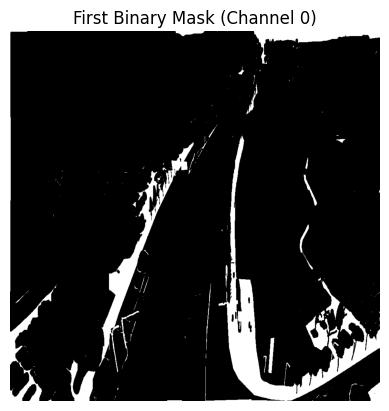

In [20]:
first_mask = masks[0, :, :, 0]

# Plot the binary mask
plt.imshow(first_mask, cmap='gray')
plt.title("First Binary Mask (Channel 0)")
plt.axis('off')  # Optional: remove axis for better visualization
plt.show()

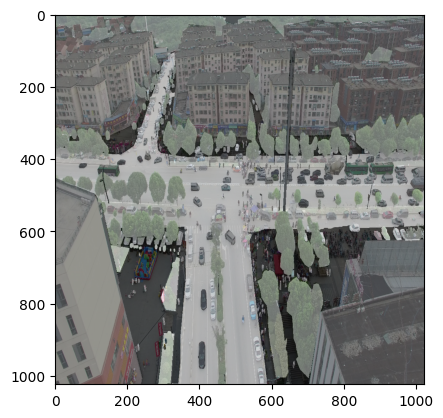

In [21]:
plt.imshow(train_img[11])
plt.imshow(train_label[11],cmap='gray',alpha=.6)
plt.show()

# **Model**

In [49]:
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))

In [50]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 1024, 1024, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 1024, 1024, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 512, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 512, 512, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 512, 512, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 256, 256, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 256, 256, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 256, 256, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 128, 128, 512)  │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 128, 128, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 128, 128, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 32, 32, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
layer_names = ['block5_conv3', 'block4_conv3', 'block3_conv3']
encoder_output = [base_model.get_layer(layer).output for layer in layer_names]

In [52]:
x= encoder_output[0]
for layer in encoder_output[1:]:
    x= keras.layers.Conv2DTranspose(filters=layer.shape[-1],kernel_size=3, strides=2, padding="same")(x)
    x= keras.layers.Concatenate()([x,layer])  
x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same")(x)

# Final Classification Layer
output = keras.layers.Conv2D(filters=8, kernel_size=1, activation='sigmoid')(x)
FCN = keras.Model(inputs =base_model.input ,outputs=output) 

In [53]:
FCN.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 1024,      │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 1024,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 512, 512,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 512, 512,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 512, 512,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 256, 256,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 256, 256,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 256, 256,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 256, 256,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 128, 128,  │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 128, 128,  │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 128, 128,  │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 128, 128,  │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 64, 64,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 64, 64,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 64, 64,    │  2,359,808 │ block5_conv1[0][

 Total params: 19,747,752 (75.33 MB)

 Trainable params: 19,747,752 (75.33 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
FCN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [154]:
FCN.fit(train_img,masks,batch_size=4,epochs=40)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6797 - loss: 0.1693
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6972 - loss: 0.1638
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7025 - loss: 0.1633
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6986 - loss: 0.1638
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7337 - loss: 0.1516
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7216 - loss: 0.1610
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7311 - loss: 0.1529
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7593 - loss: 0.1395
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7671 - loss: 0.1347
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7658 - loss: 0.1346


> **function to take 8 channels masks and make a gray scale image**

In [229]:
def convert_labl_into_gray (label):
    gray_mask = np.zeros((label.shape[0], label.shape[1],1), dtype=np.uint8)
    colors=[  0,  34,  38,  57,  75,  79,  90, 113]
    for i in range(8):
        label[:,:,i]=np.where(label[:,:,i] >=.5,1,0).astype(int)
        temp=label[:, :, i]
        gray_mask[temp == 1] = colors[i]
    return gray_mask
    # return label

> **function to take 8 channels and make a RGB image**

In [240]:
def convert_labl_into_RGB (label):
    label = label[0]  # If label has shape (batch_size, height, width, channels)

    # Initialize a color mask of the same height and width but with 3 channels for RGB
    color_mask = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

    # Define a color map for the 8 classes (8 distinct colors)
    colors = [
        [128, 0, 0],      
        [0, 128, 0],     
        [0, 0, 0],      
        [128, 64, 128],    
        [128, 128, 0],    
        [64, 0, 128],    
        [64, 64, 0],  
        [192, 0, 192]         
    ]
    
    # Iterate through the 8 channels (classes)
    for i in range(label.shape[-1]):  # Loop through the last dimension (number of classes)
        # Create a binary mask for the current class (channel)
        current_class_mask = label[:, :, i]
        
        # Apply the corresponding color to the pixels where the mask is 1
        color_mask[current_class_mask == 1] = colors[i]
    
    return color_mask



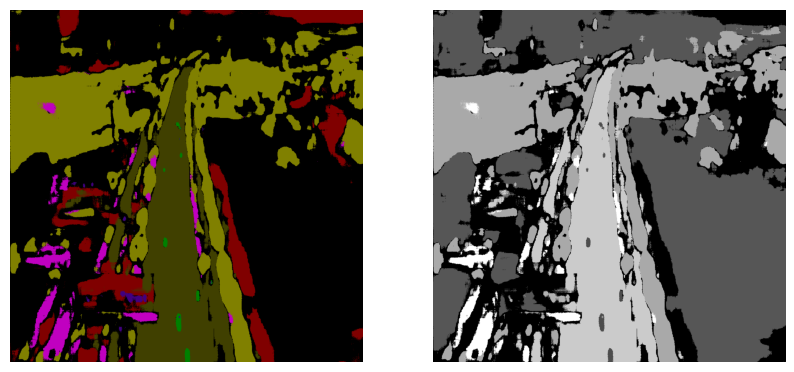

In [245]:
plt.figure(figsize=(10,18))
plt.subplot(1,2,1)
plt.imshow(l1_rgb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(l1_gray,cmap='gray')
plt.axis('off')
plt.show()

# Inference

In [251]:
test_labels=FCN.predict(test_img[:5])

2024-12-12 18:21:02.422250: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng5{} for conv (f32[5,256,257,257]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,1024,128,128]{3,2,1,0}, f32[1024,256,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-12 18:21:03.548280: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.126127201s
Trying algorithm eng5{} for conv (f32[5,256,257,257]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,1024,128,128]{3,2,1,0}, f32[1024,256,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step
